In [28]:
import os, sys, pickle, re
from os.path import join
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import fasttext as ft
from tqdm import tqdm
tqdm.pandas()
sys.path.append('helpers/')
from tweetokenize import *
data_root= config.DATA_ROOT
import text_processing, preprocess_tweet_data, config

NUM_USR_PROF_CLUSTER= '10 20 30 40 50 80 100'
ALGO_USR_PROF_CLUSTER='KMeans'

DATA_ROOT = config.DATA_ROOT
TWEET_USER_DF = join(DATA_ROOT, 'users-all.pkl') #containing profile info for all users
TWEET_USER_DF_EN = join(DATA_ROOT, 'users-en.pkl') #containing profile info for users with (detected) 'en' description
TWEET_USER_DF_EN_UNIQUE = join(DATA_ROOT, 'users-en-unique.pkl') #containing unique users with (detected) 'en' description
TWEET_USER_PROFILE_TEXT = join(DATA_ROOT, 'tweet-profile-text-en.txt') #file containing cleaned profile descriptions
CLEAN_TWEET_TEXT_EN = join(DATA_ROOT,'tweet-text-en.txt') #file containing cleaned tweet text
PROFILE_WORD_WEIGHTS = join(DATA_ROOT, 'weights.wgt') #store profile word weights
PROFILE_WORD_TFIDF = join(DATA_ROOT, 'tfidf') #store profile word tfidf scores
PROFILE_FT_MODEL = join(DATA_ROOT, 'ft-profile-sg') #fasttext model for profle desc, using skipgram to catch semantic relationships
TWEET_DF_FILE = join(DATA_ROOT, 'tweets-all.pkl')
EN_TWEET_DF_FILE = join(DATA_ROOT,'tweets-en.pkl') #dataframe with english tweets 
PRIV_TWEET_DF = join(DATA_ROOT,'tweets-priv.pkl') #dataframe containing sec/priv related tweets 
PRIV_TWEET_TEXT = join(DATA_ROOT,'tweet-text-priv.txt') #file containing sec/priv tweet texts 
PRIV_TWEET_MODEL_PATH=join(DATA_ROOT, 'priv-tweet-models/') #directory for ft and cluster models for sec/priv related tweets
PRIV_FT_MODEL  = join(PRIV_TWEET_MODEL_PATH, 'ft-priv-tweet-sg') #ft model name for sec/priv related tweets
USR_CLUSTER_DIR = join(DATA_ROOT, 'profile-cluster-models') #directory to save profile cluster models and outputs
USR_CLUSTER_MOD = join(USR_CLUSTER_DIR, 'model-KMeans-{}-0.model'.format(NUM_USR_PROF_CLUSTER))
TWEET_TOPIC_DIR = join(DATA_ROOT, 'tweet-topic') #directory to contain topic models and outputs for tweets
TWEET_SENTI_TRAIN_TEXT=join(DATA_ROOT,'tweet-senti-text.txt') #file containing text for training sentiment model

tick_font=14
lbl_font=15
leg_font=16

In [7]:
user_df = pd.read_pickle(TWEET_USER_DF)
user_df = user_df[~user_df.index.duplicated(keep='first')] 
print('# unique users: ',len(user_df))

user_df.groupby('profile_lang').username.count().sort_values(ascending=False).head(10)

# unique users:  3327801


profile_lang
en    1695090
NA    1235387
es     142066
fr      91536
de      42593
ja      18259
ar      16073
pt      15700
nl      13779
it      12737
Name: username, dtype: int64

In [6]:
user_df_en = pd.read_pickle(TWEET_USER_DF_EN_UNIQUE)
print('# unique english users: ',len(user_df_en))

# unique english users:  1698096


In [ ]:
tweet_df = pd.read_pickle(TWEET_DF_FILE)
print('# tweets ', len(tweet_df))

In [10]:
tweet_df_en = pd.read_pickle(EN_TWEET_DF_FILE)
print('# en tweets ', len(tweet_df_en))

# en tweets  9745446


In [9]:
tweet_df_en.columns

Index(['author_id', 'text', 'created_at', 'geo', 'retweets', 'replies',
       'likes', 'quote_count', 'lang', 'conversation_id',
       'context_annotations', 'entities', 'attachments', 'possibly_sensitive',
       'withheld', 'reply_settings', 'source', 'search_term', 'clean_text',
       'senti'],
      dtype='object')

In [12]:
user_df_en.user_group.unique()

array(['techie', 'personal_brand', 'business_brand', 'unknown', 'news',
       'academic', 'academic_techi'], dtype=object)

In [ ]:
uids = set(user_df_en.index)
tweet_df_en['author_group'] = tweet_df_en.progress_apply(lambda row: 
                                    user_df_en.loc[row.author_id].user_group if row.author_id in uids else 'Unknown', axis=1)

In [ ]:
tweet_df_en.groupby('author_group').author_id.count()

### Sec/Priv tweetsdf.to_pickle(data_root+'tweets-priv-processed.pkl')

In [22]:
priv_df = pd.read_pickle(data_root+'tweets-priv-processed.pkl')

#### Perc. of tweets related to sec/priv across groups

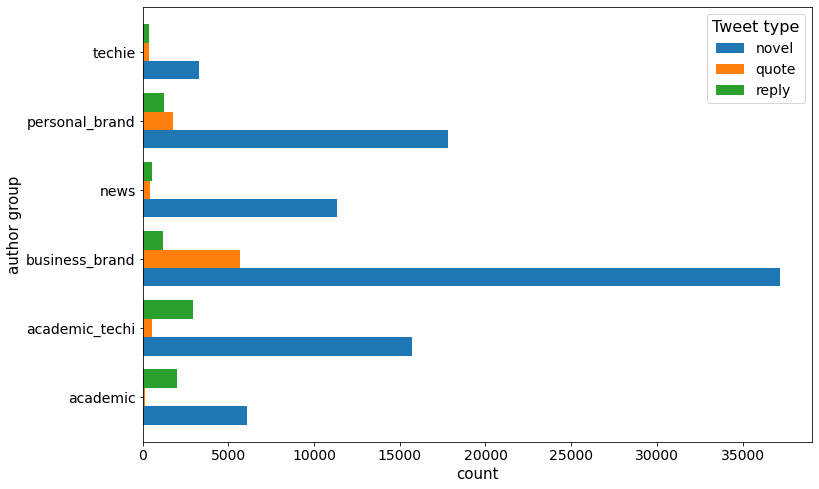

academic 8197 1.1325155052522358
academic_techi 19170 1.0698428218401965
business_brand 44097 4.647243870437408
news 12314 5.780732144701386
personal_brand 20846 1.822064231129276
techie 4042 2.861410600386524


author_group    tweet_type
academic        novel          6078
                quote           119
                reply          2000
academic_techi  novel         15710
                quote           547
                reply          2913
business_brand  novel         37210
                quote          5697
                reply          1190
news            novel         11315
                quote           455
                reply           544
personal_brand  novel         17838
                quote          1788
                reply          1220
techie          novel          3288
                quote           381
                reply           373
Name: text, dtype: int64

In [34]:
#Number of EN tweets across author groups
en_tweet_count = {'academic': 723787, 'academic_techi': 1791852, 'business_brand':948885, 'news':213018, 'personal_brand':1144087, 'techie':141259}

priv_df[priv_df.author_group!='unknown'].groupby(['author_group', 'tweet_type']).text.count().unstack().plot(kind='barh', width=.8, figsize=(12,8))
plt.yticks(fontsize=tick_font)
plt.xticks(fontsize=tick_font)
plt.xlabel('count', fontsize=lbl_font)
plt.ylabel('author group', fontsize=lbl_font)
plt.legend(title="Tweet type", title_fontsize=leg_font, fontsize=leg_font-2, fancybox=True)
plt.show()

for g in en_tweet_count.keys():
    c=priv_df[priv_df.author_group==g].text.count()
    print(g,c,c*100/en_tweet_count[g])

priv_df[priv_df.author_group!='unknown'].groupby(['author_group', 'tweet_type']).text.count()

In [20]:
priv_df.columns

Index(['author_id', 'text', 'created_at', 'geo', 'retweets', 'replies',
       'likes', 'quote_count', 'lang', 'conversation_id',
       'context_annotations', 'entities', 'attachments', 'possibly_sensitive',
       'withheld', 'reply_settings', 'source', 'search_term', 'senti', 'topic',
       'text_clean_topic', 'text_clean_senti', 'topic_cos', 'topic_con',
       'author_group'],
      dtype='object')